In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import os

In [2]:
IMAGE_SIZE = 256
batch_size = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
# Load the dataset using image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "beansLeaf",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size
)
class_names = dataset.class_names
class_names

Found 1520 files belonging to 3 classes.


['angular_leaf_spot', 'bean_rust', 'healthy']

In [4]:
# Convert dataset to NumPy arrays
images = []
labels = []
for image_batch, label_batch in dataset:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

In [5]:
# Create an instance of the ImageDataGenerator with desired augmentation options
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    vertical_flip=False,
    fill_mode='nearest'
)

In [6]:
# Create the directory if it doesn't exist
augmented_images_dir = "augmented_images"
if not os.path.exists(augmented_images_dir):
    os.makedirs(augmented_images_dir)


In [7]:
# Generate augmented images and save them to the directory
augmented_data_generator = data_augmentation.flow(images, labels, batch_size=batch_size, shuffle=True)
for i, (augmented_images, augmented_labels) in enumerate(augmented_data_generator):
    for j, augmented_image in enumerate(augmented_images):
        save_path = os.path.join(augmented_images_dir, f"augmented_image_{i * batch_size + j}.png")
        tf.keras.preprocessing.image.save_img(save_path, augmented_image)
    if (i + 1) * batch_size >= len(images):
        break


In [8]:
# Create a generator function for augmented image batches and labels
def augmented_data_generator():
    for image_batch, label_batch in data_augmentation.flow(images, labels, batch_size=batch_size, shuffle=False):
        yield image_batch, label_batch


In [9]:
# Create a new dataset from the generator function
augmented_dataset = tf.data.Dataset.from_generator(
    augmented_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.int32)
    )
)

In [10]:
# Combine the original dataset with the augmented dataset
combined_dataset = dataset.concatenate(augmented_dataset)

In [11]:
# Split the combined dataset into training and validation sets
val_size = int(0.2 * len(images))
train_dataset = combined_dataset.skip(val_size)
val_dataset = combined_dataset.take(val_size)

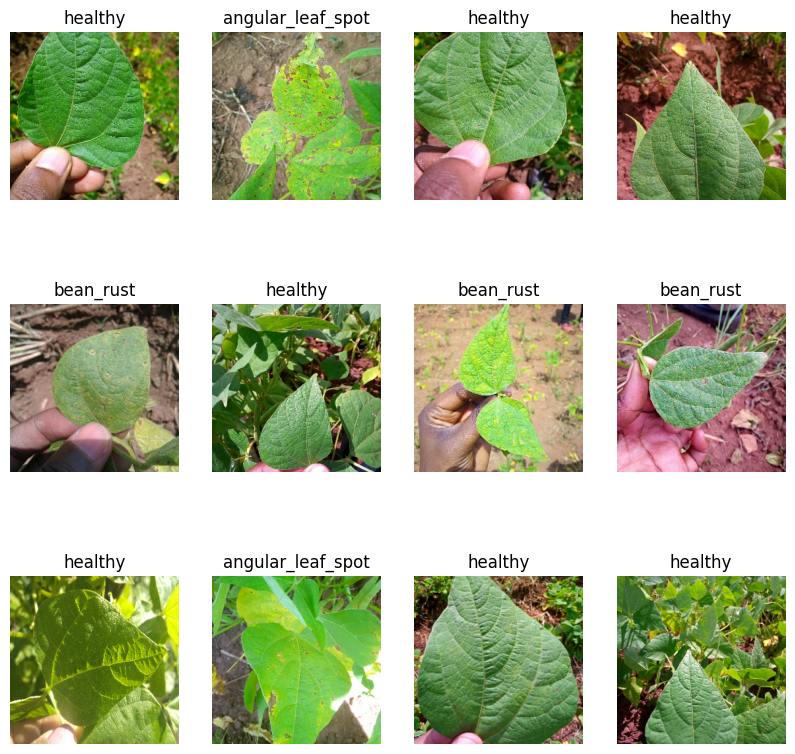

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

48

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)     

In [22]:
# Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
# Train the CRNN model
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)


Epoch 1/50
38/38 [==============================] - 223s 5s/step - loss: 10.2115 - accuracy: 0.3683 - val_loss: 1.0982 - val_accuracy: 0.3929
Epoch 2/50
38/38 [==============================] - 146s 4s/step - loss: 1.1170 - accuracy: 0.4150 - val_loss: 2.3726 - val_accuracy: 0.3929
Epoch 3/50
38/38 [==============================] - 138s 4s/step - loss: 1.1938 - accuracy: 0.4175 - val_loss: 1.0945 - val_accuracy: 0.3929
Epoch 4/50
38/38 [==============================] - 149s 4s/step - loss: 1.0919 - accuracy: 0.4183 - val_loss: 1.0928 - val_accuracy: 0.3929
Epoch 5/50
38/38 [==============================] - 141s 4s/step - loss: 1.0897 - accuracy: 0.4183 - val_loss: 1.0914 - val_accuracy: 0.3929
Epoch 6/50
38/38 [==============================] - 137s 4s/step - loss: 1.0878 - accuracy: 0.4183 - val_loss: 1.0903 - val_accuracy: 0.3929
Epoch 7/50
38/38 [==============================] - 148s 4s/step - loss: 1.0863 - accuracy: 0.4183 - val_loss: 1.0896 - val_accuracy: 0.3929
Epoch 8/50
3

In [25]:
# Evaluate the CRNN model on the test dataset
scores = model.evaluate(test_ds)

6/6 [==============================] - 41s 1s/step - loss: 1.1014 - accuracy: 0.3802


In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [27]:
print(len(acc))
print(len(val_acc))


50
50


first image to predict
actual label: healthy
1/1 [==============================] - 2s 2s/step
predicted label: healthy
first image to predict
actual label: healthy
1/1 [==============================] - 1s 1s/step
predicted label: healthy


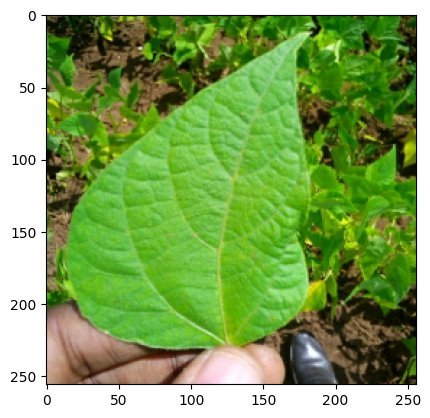

In [28]:
#  prediction on a sample image

# import numpy as np
for images_batch, labels_batch in test_ds.take(2):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[8])])

In [29]:
# function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 100ms/step


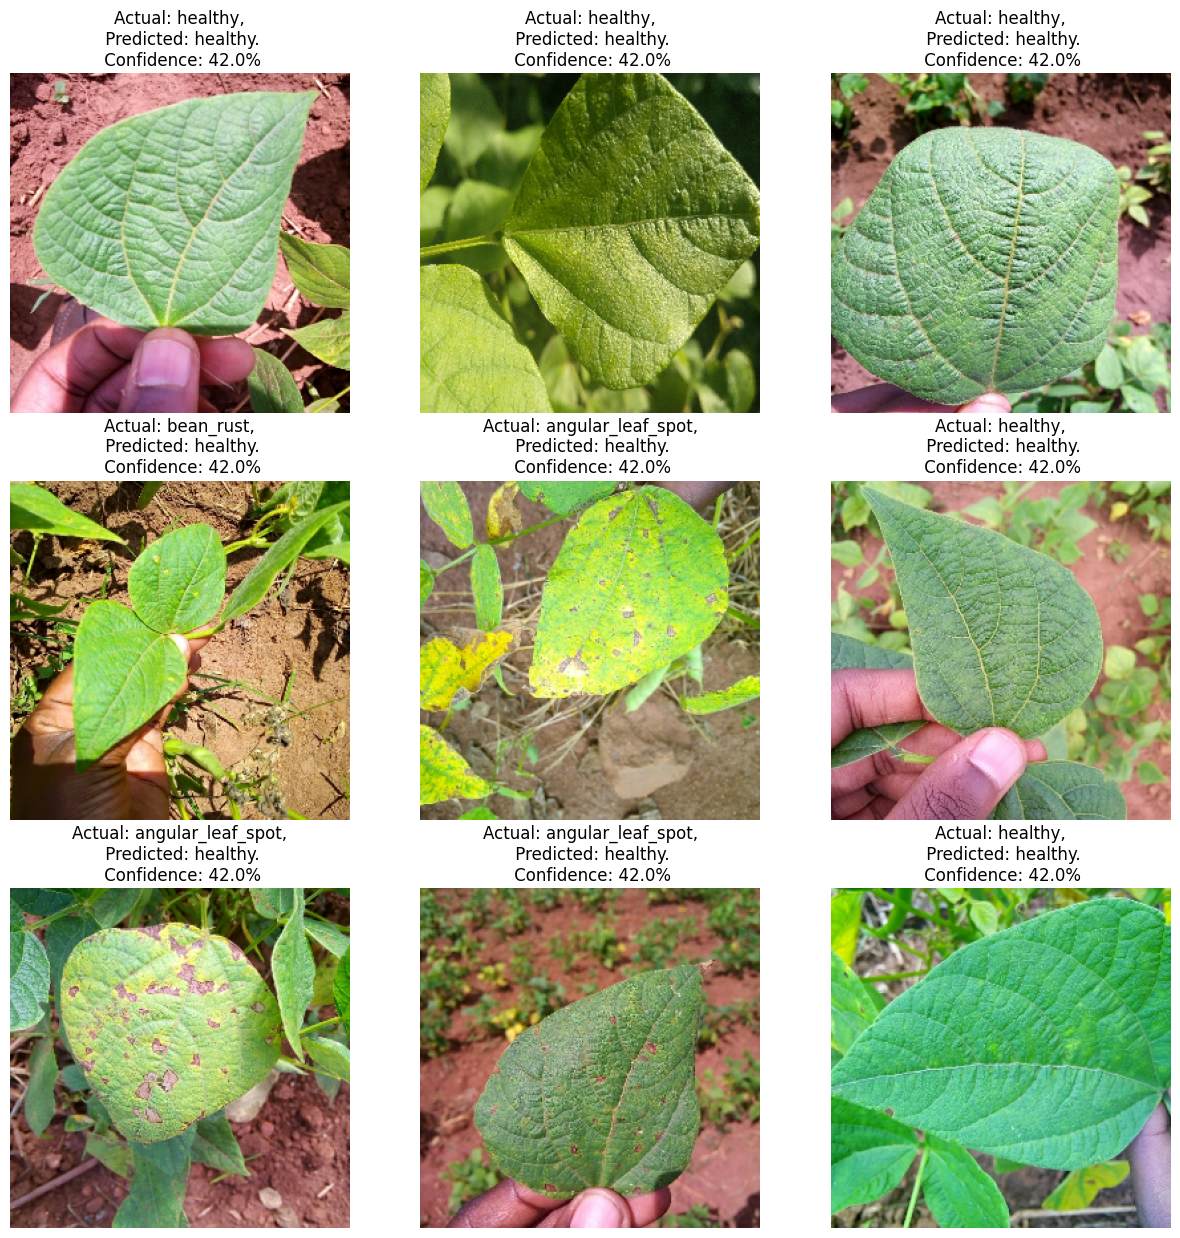

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")